In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pylab
from PIL import Image 
import pandas as pd
from scipy.stats import multivariate_normal
from sklearn.manifold import TSNE
from scipy.stats import binom
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from matplotlib import colors
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D


%matplotlib inline

# <h1><font color='blue'>The class below implements the weight initialization strategy for all the different layers of the networks.</h1>

In [2]:
class KERNELS:
    
    def __init__(self,num_kernels, kernel_size):
        
        self.num_kernels = num_kernels
        self.kernel_size = kernel_size
        
    def gen_random_weights(self):
        
        ndim = len(self.kernel_size)
       
        if ndim == 1:
            #r = np.array([random.uniform(-1,1) for i in range(self.num_kernels*self.kernel_size[0])])
            #return r.reshape([self.num_kernels, self.kernel_size.shape[0]])
            return np.random.randn(self.num_kernels, self.kernel_size.shape[0])
        if ndim == 2:
            #r = np.array([random.uniform(-1,1) for i in range(self.num_kernels*self.kernel_size[0]*self.kernel_size[1])])
           
            #return r.reshape([self.num_kernels, self.kernel_size[0], self.kernel_size[1]])
            return np.random.randn(self.num_kernels, self.kernel_size[0], self.kernel_size[1])
        else:
            #r = np.array([random.uniform(-1,1) for i in range(self.num_kernels*self.kernel_size[0]*self.kernel_size[1]*self.kernel_size[2])])
            #return r.reshape([self.num_kernels, self.kernel_size[0], self.kernel_size[1], self.kernel_size[2]])
            return np.random.randn(self.num_kernels, self.kernel_size[0], self.kernel_size[1], self.kernel_size[2])
        

# <h1><font color='blue'>The class below implements the CNN, the function accepts variable number of filters and size.The class also implements the backpropagation and weight update using 3 methods namely Vanilla GD, RMSPROP and Momentum.</h1>

In [3]:
class CONV:
    
    def __init__(self, num_kernels, kernel_size, stride, padding = False):
        
        self.stride = stride
        self.padding = padding
        self.num_kernels = num_kernels
        self.kernel_size = kernel_size
        
        wt_init = KERNELS(self.num_kernels, kernel_size)

        n = kernel_size[0] * kernel_size[1] * kernel_size[2]
        #self.kernels = np.random.normal(0, np.sqrt(2.0/n), [self.num_kernels, kernel_size[0], kernel_size[1], kernel_size[2]])
        self.kernels = wt_init.gen_random_weights()
        #self.kernels /= n
        self.input = []
        self.pad_h = 0
        self.pad_w = 0
        
        self.momentum = 0.0
        self.gradsq = 0.0
        
    def std_normalization(self, X):
        
        X1 = X.copy()
        mi = np.mean(X1)
        mx  = np.std(X1)
        X1 = (X1 -mi)/mx
        
        return X1
    
    def minmax_normalization(self, X):
        
        X1 = X.copy()
        mi = np.min(X1)
        mx  = np.max(X1)
        X1 = (X1 -mi)/(mx-mi)
        
        return X1
    
    #flip the kernel\image along the specified axis
    def flip(self, m, axis = 0):
    
        if len(m.shape) == 2:
            m = m.reshape([m.shape[0], m.shape[1], 1])

        rows, cols, chn = m.shape

        if axis == 0: #flip horizontally
            for cn in np.arange(chn):
                for r in np.arange(rows//2): 
                    t = m[r,:,cn].copy()
                    m[r,:,cn] = m[rows - r - 1,:,cn]
                    m[rows - r - 1,:,cn] = t

        if axis == 1: #flip vertically
            for cn in np.arange(chn):
                for c in np.arange(cols-1):
                    t = m[:, c, cn].copy()
                    m[:, c, cn] = m[:, cols - c - 1, cn]
                    m[:, cols - c - 1, cn] = t

        return m
    
    #pad the tensors with specified padding in horizontal and vertical directions
    def do_padding(self, img, pad_h, pad_w):
        
        ih, iw, ic = img.shape
        padded_img = np.zeros([ih + 2*pad_h, iw + 2*pad_w, ic])
    
           
        #temp = img[:, :, :].copy()
        padded_img[pad_h:ih + pad_h, pad_w:iw + pad_w,:] = img
            
        #fill padded values method ='reflection'
        for cn in np.arange(ic):
            for pdh in np.arange(pad_h):
                padded_img[pad_h - pdh - 1, :, cn] = padded_img[2*pad_h - pdh - 1, :, cn]
                padded_img[ih + pad_h + pdh, :, cn] = padded_img[ih + pdh, :, cn]
                
        for cn in np.arange(ic):
            for pdw in np.arange(pad_w):                
                padded_img[:, pad_w - pdw - 1, cn] = padded_img[:, 2*pad_w - pdw - 1, cn]
                padded_img[:, iw + pad_w + pdw, cn] = padded_img[:, iw + pdw, cn]
                
        return padded_img
    
    #perform convolution of a given image by a single kernel
    def conv3d(self, img, kernel):
        
        if len(img.shape) == 2:
            img = img.reshape([img.shape[0], img.shape[1], 1])
            
        if len(kernel.shape) == 2:
            kernel = kernel.reshape([kernel.shape[0], kernel.shape[1], 1])
            
        ih, iw, ic = img.shape
        kh, kw, kc = kernel.shape
        
        #img = self.normalization(img)
        #kernel = kernel/kernel.sum()#self.normalization(kernel)
        if ic != kc:
            print("image channels and kernel channels not matching")
            exit()
            
        if self.padding:
            pad_h = kh - 1
            pad_w = kw - 1
            padded_img = self.do_padding(img, pad_h, pad_w)
        else:
            pad_h = 0
            pad_w = 0
            padded_img = img.copy()
            
        pd_ih, pd_iw, pd_ic = padded_img.shape
        
        ot_ih = (ih - kh + 2*pad_h)//self.stride + 1
        ot_iw = (iw - kw + 2*pad_w)//self.stride + 1
        ot_ic = ic
        #print(ot_ih, ot_iw, ot_ic)
        #flip kernel
        #kernel = self.flip(self.flip(kernel, 0), 1)
        
        conv_img = np.zeros([ot_ih, ot_iw])
        
        #print("B\F::",pd_ih,pd_iw)
        for c in np.arange(ic):
            nh = 0
            for x in range(kh//2, pd_ih - kh//2, self.stride):
                nw = 0
                for y in range(kw//2, pd_iw - kw//2, self.stride):
                    #print(padded_img[x-kh//2:x+kh//2+1, y-kw//2:y+kw//2, c].shape)
                    conv_img[nh, nw] += (padded_img[x-kh//2:x+kh//2+1, y-kw//2:y+kw//2+1, c]*kernel[:,:,c]).sum()
                    nw = nw + 1
                nh = nh + 1
                    
        self.pad_h = pad_h
        self.pad_w = pad_w
        
        conv_img = conv_img[kh//2:-kh//2+1, kw//2:-kw//2+1] 
        
        return conv_img
    
    #implement the forward propagation for the cnn layer with N no. of filters
    def apply(self, X, flag = True):
         
        #print(kernels.shape)
        output_map = []
        #print("A::",len(self.input))
        if(flag):
            self.input.append(X)
        for k in range(self.num_kernels):
            output_map.append(self.conv3d(X.copy(), self.kernels[k].copy()))
        
        output_map = np.array(output_map)
        output_map = output_map.reshape([output_map.shape[1],output_map.shape[2],output_map.shape[0]])
        return np.array(output_map)
    
    #error backpropagation and graident computaiton with respect the cnn layer weights
    def backpropagate_error(self, dz):
        
        m = len(self.input)
        #print(m)
        #print("m::",m,len(self.input[0].shape))
        if len(self.input[0].shape) == 2:
            ih, iw = self.input[0].shape
            ic = 1
        else:
            ih, iw, ic = self.input[0].shape
            
        oh, ow, oc = dz.shape
        
        dw = np.zeros(self.kernels.shape)
        kh, kw, kc = self.kernels[0].shape
        
        pd_ih = ih + 2*self.pad_h
        pd_iw = iw + 2*self.pad_w
        #print("B::",pd_ih,pd_iw)
        dz_prev = np.zeros([ih, iw, ic])
        dz_prev = self.do_padding(dz_prev, self.pad_h, self.pad_w)
        #print("dz_prev::",dz_prev.shape)
        out_h, out_w, out_c = dz.shape
        
        for i in np.arange(m):     #num_samples
            img = self.input[i]
            if len(img.shape) == 2:
                img = img.reshape([ih, iw, ic])
            img = self.do_padding(img, self.pad_h, self.pad_w)
            for x in range(out_h):
                for y in range(out_w):
                    for c in np.arange(out_c):
                        
                        # Find the corners of the current "slice"
                        vert_start = self.stride * x
                        vert_end = vert_start + kh
                        horiz_start = self.stride * y
                        horiz_end = horiz_start + kw
                        
                        dz_prev[vert_start:vert_end, horiz_start:horiz_end, :] += self.kernels[c,:,:,:]*dz[x, y, c]

                        dw[c,:,:,:] += img[vert_start:vert_end, horiz_start:horiz_end, :]*dz[x, y, c]  

 
        dz_prev = dz_prev[self.pad_h:-self.pad_h,self.pad_w:-self.pad_w,:]
          
        dz_prev /= m
        dw /= m
        self.weight_update(dw)
        self.input = []
        return np.array(dz_prev)
      
    #weights update of the CNN layer with the specified method optimizer
    def weight_update(self, dw):
        
        if OPTIMIZER == 'MOMENTUM':
            self.momentum = alpha*self.momentum + (1-alpha)*dw
            self.kernels -= self.momentum*LEARNING_RATE 
        elif OPTIMIZER == 'RMSPROP':
            self.gradsq = alpha*self.gradsq + (1-alpha)*np.multiply(dw,dw)
            self.kernels -= LEARNING_RATE * dw / np.sqrt(self.gradsq+0.01)
       
        else:
            self.kernels -= LEARNING_RATE*dw
            
        #print("CNN::",np.sum(self.kernels))

# <h1><font color='blue'>The class below implements the various activation functions with backpropagation.</h1>

In [4]:
class ACTIVATION:
    
    def __init__(self, activation_type = 'relu'):
        
        self.activation_type = activation_type
        self.input = []
        
    def sigmoid(self, X):
        
        return 1/(1+np.exp(-X))
    
    def relu(self, X):
        
        output = X
        output[output < 0] = 0.0
        
        return output
    
    def tanh(self, X):
        
        val = np.exp(X)
        val_neg = np.exp(-X)
        
        return (val - val_neg)/(val + val_neg)
    
    def prelu(self, X, p = 0.5):
        
        return max(p*X, X)
    
    def softmax(self, X):
        tmp = np.exp(X)
        output = tmp / np.sum(tmp)
        return output
    
    def apply(self, X, flag = True):
        
        if(flag):
            self.input.append(X)
        if self.activation_type == 'sigmoid':
            return self.sigmoid(X)
        
        if self.activation_type == 'relu':
            return self.relu(X)
        
        if self.activation_type == 'tanh':
            return self.tanh(X)
        
        if self.activation_type == 'prelu':
            return self.prelu(X, 0.5)
        
        if self.activation_type == 'softmax':
            return self.softmax(X)
        
    def backpropagate_error(self, Y, S):
        
        m = len(self.input)
        #print("M::",m)
        if self.activation_type == 'softmax':
            g = np.zeros([len(Y[0])])
            for i in np.arange(len(Y)):
                g += np.array(S[i]) - np.array(Y[i])

        elif self.activation_type == 'relu':
            
            g = np.zeros(self.input[0].shape)
            for smpl in self.input:
                g += (smpl > 0) + 0.0
            g = np.array(g)
            
            g = g*S
        g /= m
        self.input = []   
        return g

# <h1><font color='blue'>The class below implements the pooling function with max and average strategy and backpropagation.</h1>

In [5]:
class POOLING:
    
    def __init__(self, stride, pool_size, pool_type):
        
        self.stride = stride
        self.pool_size = pool_size
        self.pool_type = pool_type
        
        self.input = []
        
    def avg_polling(self, X):
        
        ih, iw, ic = X.shape
        
        oh = ih//(self.stride)
        ow = iw//(self.stride)
        oc = ic
        
        output_map = np.zeros([oh, ow, oc])
        
        for c in range(0, ic):
            k = 0
            for i in range(0, ih - self.pool_size, self.stride + 1):
                l = 0
                for j in range(0, iw - self.pool_size, self.stride + 1):
                    output_map[k, l, c] = np.mean(X[i:i+self.pool_size, j:j+self.pool_size, c])
                    l = l + 1
                k = k + 1
        
        self.input.append(X)
        self.output.append(output_map)
        
        return output_map
    
    def max_polling(self, X):
        
        #print(X.shape)
        ih, iw, ic = X.shape
        
        oh = ih//(self.stride)
        ow = iw//(self.stride)
        oc = ic
        
        output_map = np.zeros([oh, ow, oc])
        
        for c in range(0, ic):
            k = 0
            for i in range(0, ih - self.pool_size + 1, self.stride):
                l = 0
                for j in range(0, iw - self.pool_size + 1, self.stride):
                    output_map[k, l, c] = np.max(X[i:i+self.pool_size, j:j+self.pool_size, c])
                    l = l + 1
                k = k + 1
        
        return output_map
    
    def apply(self, X, flag = True):
        
        if(flag):
            self.input.append(X)
        if self.pool_type == 'avg':
            return self.avg_polling(X)
        
        else:
            return self.max_polling(X)
        
    def create_mask(self, X):
        
        mask = (X == np.max(X))
        
        return mask
    
    def backpropagate_error(self, dz):
        
        m = len(self.input)
        
        n_H_prev, n_W_prev, n_C_prev = self.input[0].shape
        n_H, n_W, n_C = dz.shape

        # Initialize dA_prev with zeros
        dz_prev = np.zeros(self.input[0].shape)
            
        for i in np.arange(m):
            smpl = self.input[i]
            for h in range(n_H):               # loop on the vertical axis
                for w in range(n_W):               # loop on the horizontal axis
                    for c in range(n_C):           # loop over the channels (depth)

                        # Find the corners of the current "slice" (≈4 lines)
                        vert_start  = h * self.stride
                        vert_end    = h * self.stride + self.pool_size
                        horiz_start = w * self.stride
                        horiz_end   = w * self.stride + self.pool_size
                        
                        # Use the corners and "c" to define the current slice from a_prev (≈1 line)
                        pool_win = smpl[vert_start:vert_end, horiz_start:horiz_end, c].copy()
                        # Create the mask from a_prev_slice
                        mask = self.create_mask(pool_win)
                        # Set dA_prev to be dA_prev + (the mask multiplied by the correct entry of dA)
                        dz_prev[vert_start:vert_end, horiz_start:horiz_end, c] += mask * dz[h, w, c]
                   
        dz_prev /= m
                    
        self.input = [] 
        return dz_prev


# <h1><font color='blue'>The bottleneck layer to flastten the output of the CNN layer to a vector and corresponding backpropagation. The layer don't have any learning parameter./h1>

In [6]:
class FLATTEN:
    
    def __init__(self, input_dim, output_dim, transform_type = 'identical'):
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.transform_type = transform_type
        
        if self.transform_type == 'weight':
            #random initialization of weights
            wt_init = KERNELS(1, [self.input_dim, self.output_dim])
            self.weights = wt_init.gen_random_weights()
            
        self.input_shape = None
        
    def apply(self, X, flag = True):
        
        self.input_shape = X.shape
        X = X.flatten()
        
        if self.transform_type == 'identical':
            return X
        
        return np.dot(X.T, self.weights[0])
    
    def backpropagate_error(self, dz):
              
        prev_dz = dz.reshape(self.input_shape)
  
        return prev_dz

# <h1><font color='blue'>A multi-perceptron feed-forward and back propagation function which outputs the relu(WT*X).</h1>

In [7]:
class MLP:
    
    def __init__(self, input_dim, output_dim, activation_type = 'relu'):

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.activation = activation_type
        
        #random initialization of weights
        wt_init = KERNELS(1, [self.input_dim, self.output_dim])
        self.weights = wt_init.gen_random_weights()/np.sqrt(self.input_dim + self.output_dim)
        
        self.input = []
        self.output = []
        self.act = None
        self.momentum = 0.0
        self.gradsq = 0.0
        
    def apply(self, X, flag = True):
        
        self.input = []
        self.output = []
       
        Y = np.dot(X, self.weights[0])
        
        #apply activation function
        if self.activation != 'None':
            self.act = ACTIVATION(self.activation)  
            Yhat = self.act.apply(Y)
        else:
            Yhat = Y
        
        if(flag):
            self.input.append(X.reshape([X.size, 1]))
            self.output.append(Yhat)
        
        return Yhat
    
    def backpropagate_error(self, dz):
        
        #print(self.weights)
        if self.activation != 'None':
            dz = self.act.backpropagate_error([], dz)
        prev_dz = np.zeros(self.input[0].shape)
        
        dw = np.zeros(self.weights.shape)
        dz = dz.reshape([len(dz),1])
        m = len(self.input)

        for i in np.arange(m):
            dw += np.dot(self.input[i], dz.T)
        dw /= m 
        prev_dz = np.dot(self.weights[0], dz)
        self.weight_update(dw)
        self.input = [] 
        return prev_dz
    
    def weight_update(self, dw):
        
       
        if OPTIMIZER == 'MOMENTUM':
            self.momentum = alpha*self.momentum + (1-alpha)*dw
            self.weights -= self.momentum*LEARNING_RATE 
        elif OPTIMIZER == 'RMSPROP':
            self.gradsq = alpha*self.gradsq + (1-alpha)*np.multiply(dw,dw)
            self.weights -= LEARNING_RATE * dw / np.sqrt(self.gradsq + 0.01)
        else:
              self.weights -= dw * LEARNING_RATE
                
        #print("MLP::",np.sum(self.weights))

# <h1><font color='blue'>Loading the MNIST dataset using pytorch module</h1>

In [8]:
import torchvision.datasets as datasets
import torchvision
import torch

In [9]:
img_dir = 'mnist/train_data/'

In [10]:
mnist_trainset = datasets.MNIST(root= img_dir, train=True, download=True, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()]))

In [11]:
mnist_trainset

Dataset MNIST
    Number of datapoints: 60000
    Root location: mnist/train_data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [12]:
mnist_data = torchvision.datasets.MNIST(img_dir )
data_loader = torch.utils.data.DataLoader(mnist_data,
                                          batch_size=4,
                                          shuffle=True,
                                          num_workers=1)

In [13]:
data_loader.dataset.data.shape

torch.Size([60000, 28, 28])

In [14]:
data_loader.dataset.train_labels

C:\Users\ankurgu\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


tensor([5, 0, 4,  ..., 5, 6, 8])

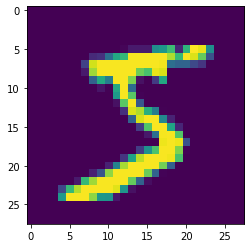

In [15]:
plt.imshow(data_loader.dataset.data[0].numpy())

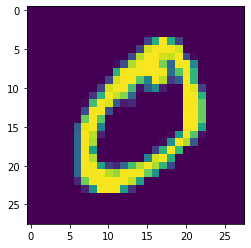

In [16]:
plt.imshow(data_loader.dataset.data[1].numpy())

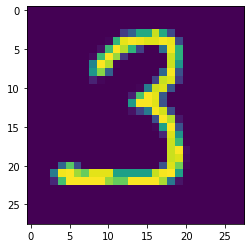

In [17]:
plt.imshow(data_loader.dataset.data[19758].numpy())

# <h1><font color='blue'>The below function implements the strategy to create training and validation set. The function simply return the index of samples for both training and validation set..</h1>

In [16]:
def train_test_split(data_loader):
    
    imgs =  data_loader.dataset.data
    lbl = data_loader.dataset.train_labels.numpy()
    
    train_idx = []
    test_idx = []
    for c in np.arange(10):
        
        idx = np.where(lbl == c)[0]
        np.random.shuffle(idx)
        
        train_idx.append(idx[:100])
        test_idx.append(idx[100:110])
        
    return np.array(train_idx).flatten().tolist(), np.array(test_idx).flatten().tolist()

In [17]:
train_set_idx, test_set_idx = train_test_split(data_loader)

# <h1><font color='blue'>Fully connected network to test backpropagation and optimization methods. The input is flatten into a single vector and then pass through the hidden layer.</h1>

In [24]:
class FCN_MODEL:
    
    def __init__(self, input_size, output_size):
        
        self.input_size = input_size
        self.output_size = output_size
        self.model = []
        
    def build_model(self):
        
        flatten_layer1 = FLATTEN(input_dim = self.input_size, output_dim = 28*28, transform_type = 'identical')
        mlp_layer2 = MLP(input_dim = 28*28, output_dim = 10, activation_type = 'None')
        #mlp_layer3 = MLP(input_dim = 128, output_dim = 10, activation_type = 'relu')
        act_layer4 = ACTIVATION(activation_type = 'softmax')
        

        self.model.append(flatten_layer1)
        self.model.append(mlp_layer2)
        #self.model.append(mlp_layer3)
        self.model.append(act_layer4)
       
    
    def forward_pass(self, X, flag = True):
        
        Y = X.copy()
        Y = Y.astype('float32')
        Y = Y/255
        Y = self.model[0].apply(Y)
        Y = self.model[1].apply(Y, flag)
        Y = self.model[2].apply(Y)
            
        return Y
    
    def do_train(self, data_loader, train_idx, test_idx, epochs, batch_size):
        
        temp = []
        for i in np.arange(10):
            temp.append([i]*100)

        temp = np.array(temp).flatten()

        train_y = np.zeros((temp.size, temp.max() + 1))

        train_y[np.arange(temp.size), temp] = 1
        
        train_lbls = {}
        i = 0
        for keys in train_idx:
            train_lbls[keys] = train_y[i]
            i = i + 1
        
        train_index = train_idx.copy()
        num_iter = len(train_idx)//batch_size
        #print(num_iter)
        train_loss = 0
        for steps in np.arange(epochs):
            #shuffle the trianing data
            print("Epoch::",steps)
            np.random.shuffle(train_idx)
            for i in np.arange(num_iter):
                Yhat = []
                Y = []
                train_loss = 0
                
                #print("epoch::"+str(steps)+" iter::"+str(i))
                for j in np.arange(batch_size):
                    #print(i*j + j)
                    im = data_loader.dataset.data[train_idx[i*batch_size + j]].numpy()
                    o = self.forward_pass(im)
                    #print(o)
                    Yhat.append(o)
                    Y.append(train_lbls[train_idx[i*batch_size + j]].tolist())
                    #print(Y)
                    train_loss += self.compute_loss(train_lbls[train_idx[i*batch_size + j]].tolist(), o)
                    
                train_loss = train_loss * (-1/batch_size)
                #print(train_loss)
                self.backward_pass(Y, Yhat)
            train_acc = self.do_prediction(data_loader, train_index)
            test_acc = self.do_prediction(data_loader, test_idx)
            print("Train-acc::" + str(train_acc) + ", Test-acc::" + str(test_acc))
                    
        
    def compute_loss(self, Y, Yhat):
        #compute the cross-entropy loss per sample
        ones = np.ones(len(Y))
        cost = (np.dot(Y, np.log(Yhat).T) + np.dot((ones-Y), np.log(ones-Yhat).T))
        cost = np.squeeze(cost)
        return cost
        
    def backward_pass(self, Y, Yhat):
        #backpropagate the error
        
        dz = self.model[-1].backpropagate_error(Y, Yhat)
        dz = self.model[-2].backpropagate_error(np.array(dz))
        dz = self.model[-3].backpropagate_error(dz)
        
        
    def do_prediction(self, data_loader, test_idx):
        
        test_lbls = []
        count = len(test_idx)//10
        for i in np.arange(10):
            test_lbls.append([i]*count)

        test_lbls = np.array(test_lbls).flatten()
        youtput = []
        for idx in test_idx:
            #print(idx)
            im = data_loader.dataset.data[idx].numpy()
            o = self.forward_pass(im, False)
            yhat = np.argmax(o)
            youtput.append(yhat)
        #print(youtput)    
        correct_predictions = 0
        for i in np.arange(test_lbls.size):
            
            if test_lbls[i] == youtput[i]:
                correct_predictions += 1
        
        return correct_predictions*100.0/len(youtput)

# <h1><font color='blue'>Test the Vanilla Gradient Descent Optimization.</h1>

In [25]:
OPTIMIZER = 'GD'
alpha = 0.9
fcn_model = FCN_MODEL(28, 10)
fcn_model.build_model()
LEARNING_RATE = .001
fcn_model.do_train(data_loader, train_set_idx.copy(), test_set_idx.copy(), epochs = 40, batch_size = 1)

Epoch:: 0
Train-acc::66.6, Test-acc::65.0
Epoch:: 1
Train-acc::79.8, Test-acc::74.0
Epoch:: 2
Train-acc::81.0, Test-acc::72.0
Epoch:: 3
Train-acc::84.2, Test-acc::75.0
Epoch:: 4
Train-acc::85.3, Test-acc::76.0
Epoch:: 5
Train-acc::86.7, Test-acc::79.0
Epoch:: 6
Train-acc::86.7, Test-acc::78.0
Epoch:: 7
Train-acc::87.5, Test-acc::81.0
Epoch:: 8
Train-acc::87.8, Test-acc::81.0
Epoch:: 9
Train-acc::88.3, Test-acc::82.0
Epoch:: 10
Train-acc::88.8, Test-acc::82.0
Epoch:: 11
Train-acc::89.2, Test-acc::83.0
Epoch:: 12
Train-acc::89.5, Test-acc::81.0
Epoch:: 13
Train-acc::89.8, Test-acc::82.0
Epoch:: 14
Train-acc::89.8, Test-acc::81.0
Epoch:: 15
Train-acc::90.1, Test-acc::82.0
Epoch:: 16
Train-acc::90.6, Test-acc::82.0
Epoch:: 17
Train-acc::90.8, Test-acc::81.0
Epoch:: 18
Train-acc::91.0, Test-acc::82.0
Epoch:: 19
Train-acc::91.3, Test-acc::81.0
Epoch:: 20
Train-acc::91.7, Test-acc::81.0
Epoch:: 21
Train-acc::91.8, Test-acc::81.0
Epoch:: 22
Train-acc::91.7, Test-acc::81.0
Epoch:: 23
Train-acc:

# <h1><font color='blue'>Test the Momentum based Optimization.</h1>

In [26]:
OPTIMIZER = 'MOMENTUM'
alpha = 0.9
fcn_model = FCN_MODEL(28, 10)
fcn_model.build_model()
LEARNING_RATE = .001
fcn_model.do_train(data_loader, train_set_idx.copy(), test_set_idx.copy(), epochs = 40, batch_size = 1)

Epoch:: 0
Train-acc::67.5, Test-acc::66.0
Epoch:: 1
Train-acc::78.4, Test-acc::73.0
Epoch:: 2
Train-acc::82.4, Test-acc::77.0
Epoch:: 3
Train-acc::84.9, Test-acc::79.0
Epoch:: 4
Train-acc::85.8, Test-acc::79.0
Epoch:: 5
Train-acc::86.6, Test-acc::80.0
Epoch:: 6
Train-acc::87.6, Test-acc::82.0
Epoch:: 7
Train-acc::87.8, Test-acc::80.0
Epoch:: 8
Train-acc::88.5, Test-acc::84.0
Epoch:: 9
Train-acc::88.8, Test-acc::85.0
Epoch:: 10
Train-acc::89.2, Test-acc::86.0
Epoch:: 11
Train-acc::89.7, Test-acc::85.0
Epoch:: 12
Train-acc::89.8, Test-acc::85.0
Epoch:: 13
Train-acc::90.4, Test-acc::86.0
Epoch:: 14
Train-acc::90.4, Test-acc::87.0
Epoch:: 15
Train-acc::90.5, Test-acc::85.0
Epoch:: 16
Train-acc::90.8, Test-acc::85.0
Epoch:: 17
Train-acc::90.8, Test-acc::86.0
Epoch:: 18
Train-acc::91.1, Test-acc::87.0
Epoch:: 19
Train-acc::91.4, Test-acc::86.0
Epoch:: 20
Train-acc::91.2, Test-acc::84.0
Epoch:: 21
Train-acc::91.8, Test-acc::86.0
Epoch:: 22
Train-acc::92.0, Test-acc::86.0
Epoch:: 23
Train-acc:

# <h1><font color='blue'>Test the RMSPROP Optimization.</h1>

In [27]:
OPTIMIZER = 'RMSPROP'
alpha = 0.9
fcn_model = FCN_MODEL(28, 10)
fcn_model.build_model()
LEARNING_RATE = .001
fcn_model.do_train(data_loader, train_set_idx.copy(), test_set_idx.copy(), epochs = 40, batch_size = 1)

Epoch:: 0
Train-acc::86.0, Test-acc::81.0
Epoch:: 1
Train-acc::87.5, Test-acc::84.0
Epoch:: 2
Train-acc::89.8, Test-acc::84.0
Epoch:: 3
Train-acc::90.8, Test-acc::85.0
Epoch:: 4
Train-acc::91.4, Test-acc::84.0
Epoch:: 5
Train-acc::92.2, Test-acc::80.0
Epoch:: 6
Train-acc::92.8, Test-acc::87.0
Epoch:: 7
Train-acc::92.5, Test-acc::83.0
Epoch:: 8
Train-acc::92.9, Test-acc::86.0
Epoch:: 9
Train-acc::93.7, Test-acc::84.0
Epoch:: 10
Train-acc::93.6, Test-acc::85.0
Epoch:: 11
Train-acc::94.4, Test-acc::86.0
Epoch:: 12
Train-acc::94.4, Test-acc::84.0
Epoch:: 13
Train-acc::94.7, Test-acc::83.0
Epoch:: 14
Train-acc::95.0, Test-acc::85.0
Epoch:: 15
Train-acc::94.7, Test-acc::83.0
Epoch:: 16
Train-acc::95.4, Test-acc::84.0
Epoch:: 17
Train-acc::95.5, Test-acc::80.0
Epoch:: 18
Train-acc::95.5, Test-acc::82.0
Epoch:: 19
Train-acc::95.3, Test-acc::84.0
Epoch:: 20
Train-acc::96.0, Test-acc::86.0
Epoch:: 21
Train-acc::96.2, Test-acc::82.0
Epoch:: 22
Train-acc::96.2, Test-acc::81.0
Epoch:: 23
Train-acc:

# # <h1><font color='blue'>CNN-Architecture</h1>

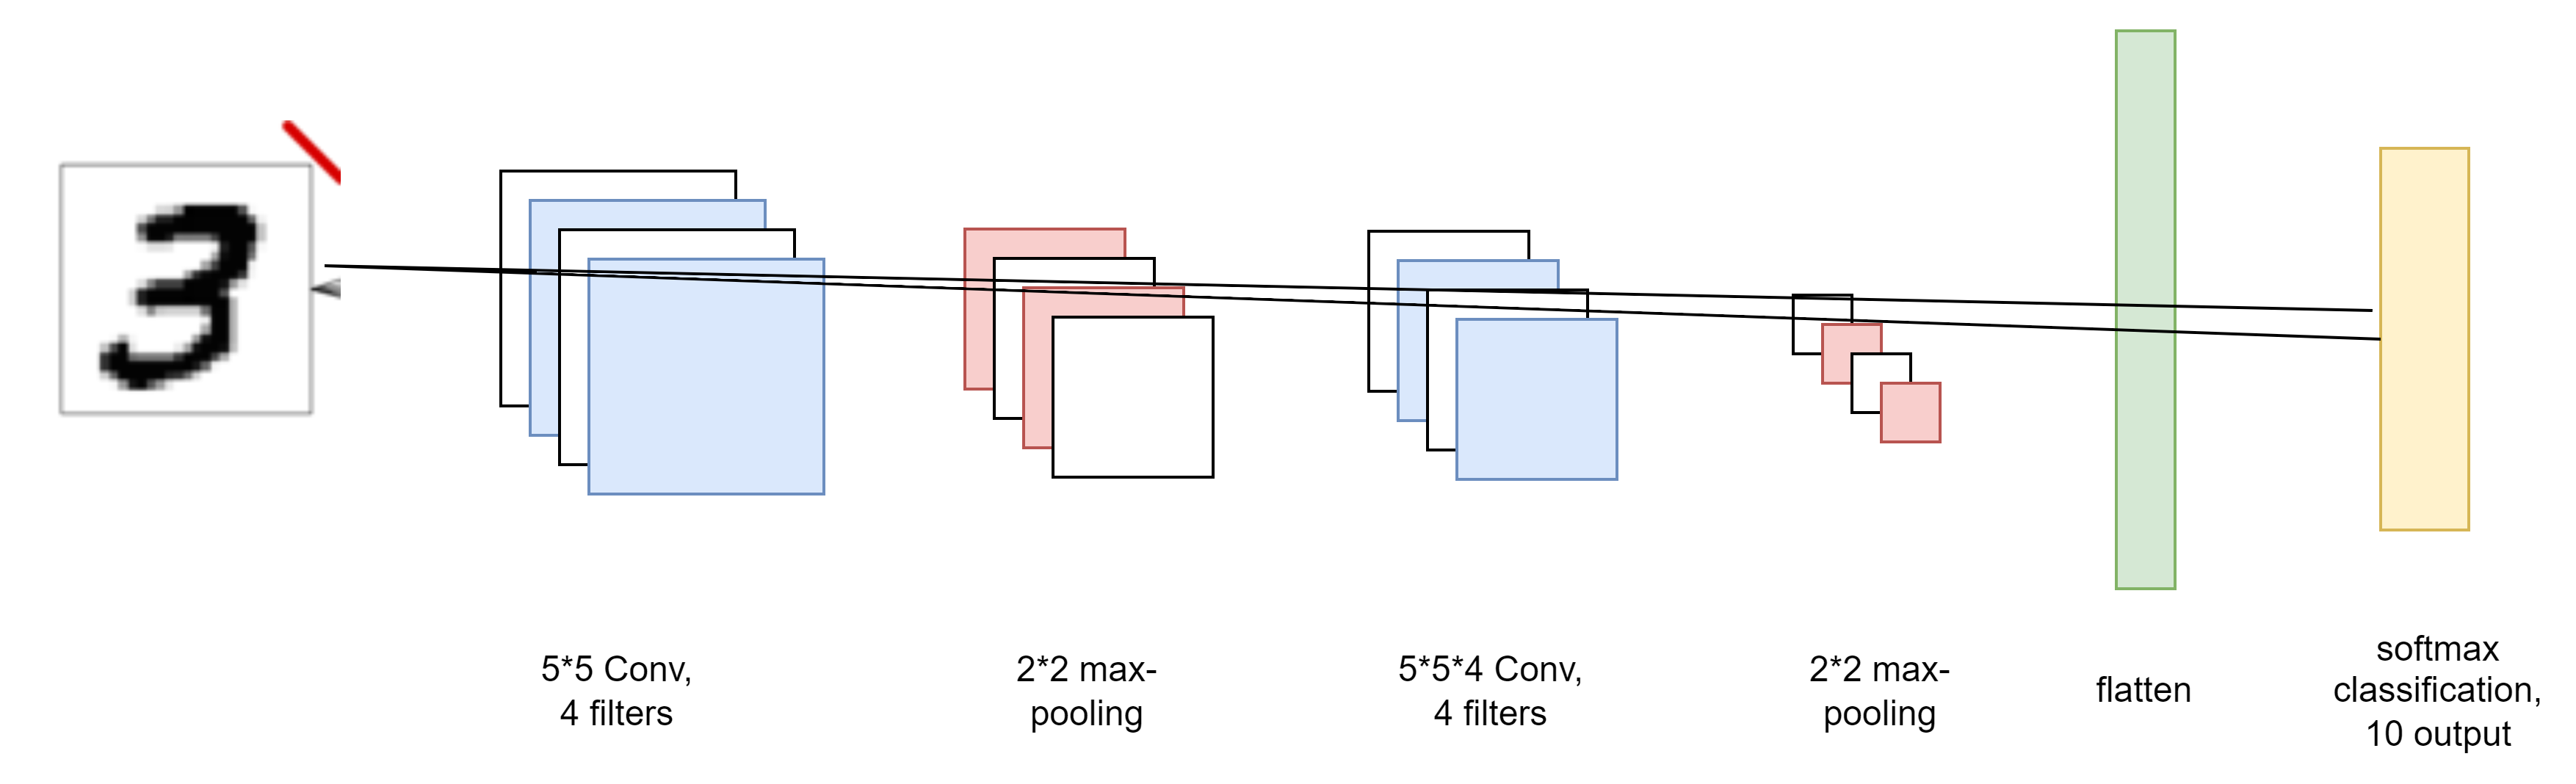

# <h1><font color='blue'>The below class implements the above architecture by combining different components and also implements forward and back propagation through the network</h1>

In [18]:
class CNN_MODEL:
    
    def __init__(self, input_size, output_size):
        
        self.input_size = input_size
        self.output_size = output_size
        self.model = []
        
    def build_model(self):
        
        cnn_layer1 = CONV(num_kernels = 4, kernel_size = [5,5,1], stride = 1, padding = True)
        act_layer1 = ACTIVATION(activation_type = 'relu')
        polling_layer1 = POOLING(stride = 2, pool_size = 2, pool_type = 'max')
        
        cnn_layer2 = CONV(num_kernels = 4, kernel_size = [5,5,4], stride = 1, padding = True)
        act_layer2 = ACTIVATION(activation_type = 'relu')
        polling_layer2 = POOLING(stride = 2, pool_size = 2, pool_type = 'max')
        
        input_dim = (self.input_size//4)
        flatten_layer1 = FLATTEN(input_dim = input_dim*input_dim*4, output_dim = input_dim*input_dim*4, transform_type = 'identical')
        mlp_layer1 = MLP(input_dim = input_dim*input_dim*4, output_dim = self.output_size, activation_type = 'None')
        act_layer3 = ACTIVATION(activation_type = 'softmax')
        
        self.model.append(cnn_layer1)
        self.model.append(act_layer1)
        self.model.append(polling_layer1)
        self.model.append(cnn_layer2)
        self.model.append(act_layer2)
        self.model.append(polling_layer2)
        self.model.append(flatten_layer1)
        self.model.append(mlp_layer1)
        self.model.append(act_layer3)

    def forward_pass(self, X, flag = True):
        
        Y = X.copy()
        Y = Y.astype('float32')
        Y = Y/255
        for layers in self.model:
            #print(layers,Y.shape)
            Y = layers.apply(Y, flag)
            
        return Y
    
    def do_train(self, data_loader, train_idx, test_idx, epochs, batch_size):
        
        temp = []
        for i in np.arange(10):
            temp.append([i]*100)

        temp = np.array(temp).flatten()

        train_y = np.zeros((temp.size, temp.max() + 1))

        train_y[np.arange(temp.size), temp] = 1
        
        train_lbls = {}
        i = 0
        for keys in train_idx:
            train_lbls[keys] = train_y[i]
            i = i + 1
        
        train_index = train_idx.copy()
        num_iter = len(train_idx)//batch_size
        #print(num_iter)
        train_loss = 0
        for steps in np.arange(epochs):
            #shuffle the trianing data
            print("Epoch::",steps)
            np.random.shuffle(train_idx)
            for i in np.arange(num_iter):
                Yhat = []
                Y = []
                train_loss = 0
                
                #print("epoch::"+str(steps)+" iter::"+str(i))
                for j in np.arange(batch_size):
                    #print(i*j + j)
                    img = data_loader.dataset.data[train_idx[i*batch_size + j]].numpy()
                    #img = img.astype('float32')
                    #img = img/255
                    o = self.forward_pass(img)
                    #print(o)
                    Yhat.append(o)
                    Y.append(train_lbls[train_idx[i*batch_size + j]].tolist())
                    #print(Y)
                    train_loss += self.compute_loss(train_lbls[train_idx[i*batch_size + j]].tolist(), o)
                    
                train_loss = train_loss * (-1/batch_size)
                #print(train_loss)
                self.backward_pass(Y, Yhat)
            train_acc = self.do_prediction(data_loader, train_index)
            test_acc = self.do_prediction(data_loader, test_idx)
            print("Train-acc::" + str(train_acc) + ", Test-acc::" + str(test_acc))
        
    def compute_loss(self, Y, Yhat):
        #compute the cross-entropy loss per sample
        ones = np.ones(len(Y))
        cost = (np.dot(Y, np.log(Yhat).T) + np.dot((ones-Y), np.log(ones-Yhat).T))
        cost = np.squeeze(cost)
        return cost
        
    def backward_pass(self, Y, Yhat):
        #backpropagate the error
        
        dz = self.model[-1].backpropagate_error(Y, Yhat)
        
        dz = self.model[-2].backpropagate_error(np.array(dz))
        #print(self.model[-2],dz.shape)
        dz = self.model[-3].backpropagate_error(dz)
        #print(self.model[-3],dz.shape)
        dz = self.model[-4].backpropagate_error(dz)
        #print(self.model[-4],dz.shape)
        dz = self.model[-5].backpropagate_error([],dz)
        #print(self.model[-5],dz.shape)
        dz = self.model[-6].backpropagate_error(dz)
        #print(self.model[-6],dz.shape)
        dz = self.model[-7].backpropagate_error(dz)
        #print(self.model[-7],dz.shape)
        dz = self.model[-8].backpropagate_error([], dz)
        #print(self.model[-8],dz.shape)
        dz = self.model[-9].backpropagate_error(dz)
        #print(self.model[-9],dz.shape)
        
    def do_prediction(self, data_loader, test_idx):
        
        test_lbls = []
        count = len(test_idx)//10
        for i in np.arange(10):
            test_lbls.append([i]*count)

        test_lbls = np.array(test_lbls).flatten()
        youtput = []
        for idx in test_idx:
            #print(idx)
            img = data_loader.dataset.data[idx].numpy()
            #img = img.astype('float32')
            #img = img/255
            o = self.forward_pass(img, False)
            yhat = np.argmax(o)
            youtput.append(yhat)
        #print(youtput)    
        correct_predictions = 0
        for i in np.arange(test_lbls.size):
            
            if test_lbls[i] == youtput[i]:
                correct_predictions += 1
        
        return correct_predictions*100.0/len(youtput)

# <h1><font color='blue'>Run the CNN model with GD optimization.</h1>

In [28]:
OPTIMIZER = 'GD'
alpha = 0.9
cnn_model = CNN_MODEL(28, 10)
cnn_model.build_model()
LEARNING_RATE = .001
cnn_model.do_train(data_loader, train_set_idx.copy(), test_set_idx.copy(), epochs = 15, batch_size = 1)

Epoch:: 0


<ipython-input-18-40ac57285bf9>:99: RuntimeWarning: divide by zero encountered in log
  cost = (np.dot(Y, np.log(Yhat).T) + np.dot((ones-Y), np.log(ones-Yhat).T))


Train-acc::52.4, Test-acc::42.0
Epoch:: 1
Train-acc::76.8, Test-acc::68.0
Epoch:: 2
Train-acc::74.5, Test-acc::61.0
Epoch:: 3
Train-acc::75.2, Test-acc::63.0
Epoch:: 4
Train-acc::73.9, Test-acc::57.0
Epoch:: 5
Train-acc::76.0, Test-acc::57.0
Epoch:: 6
Train-acc::71.1, Test-acc::55.0
Epoch:: 7
Train-acc::73.3, Test-acc::56.0
Epoch:: 8
Train-acc::66.8, Test-acc::57.0
Epoch:: 9
Train-acc::67.4, Test-acc::57.0
Epoch:: 10
Train-acc::63.6, Test-acc::58.0
Epoch:: 11
Train-acc::62.1, Test-acc::49.0
Epoch:: 12
Train-acc::61.8, Test-acc::48.0
Epoch:: 13
Train-acc::53.3, Test-acc::40.0
Epoch:: 14
Train-acc::51.8, Test-acc::46.0


# <h1><font color='blue'>Visualizing the Receptive field from the CNN layer.</h1>

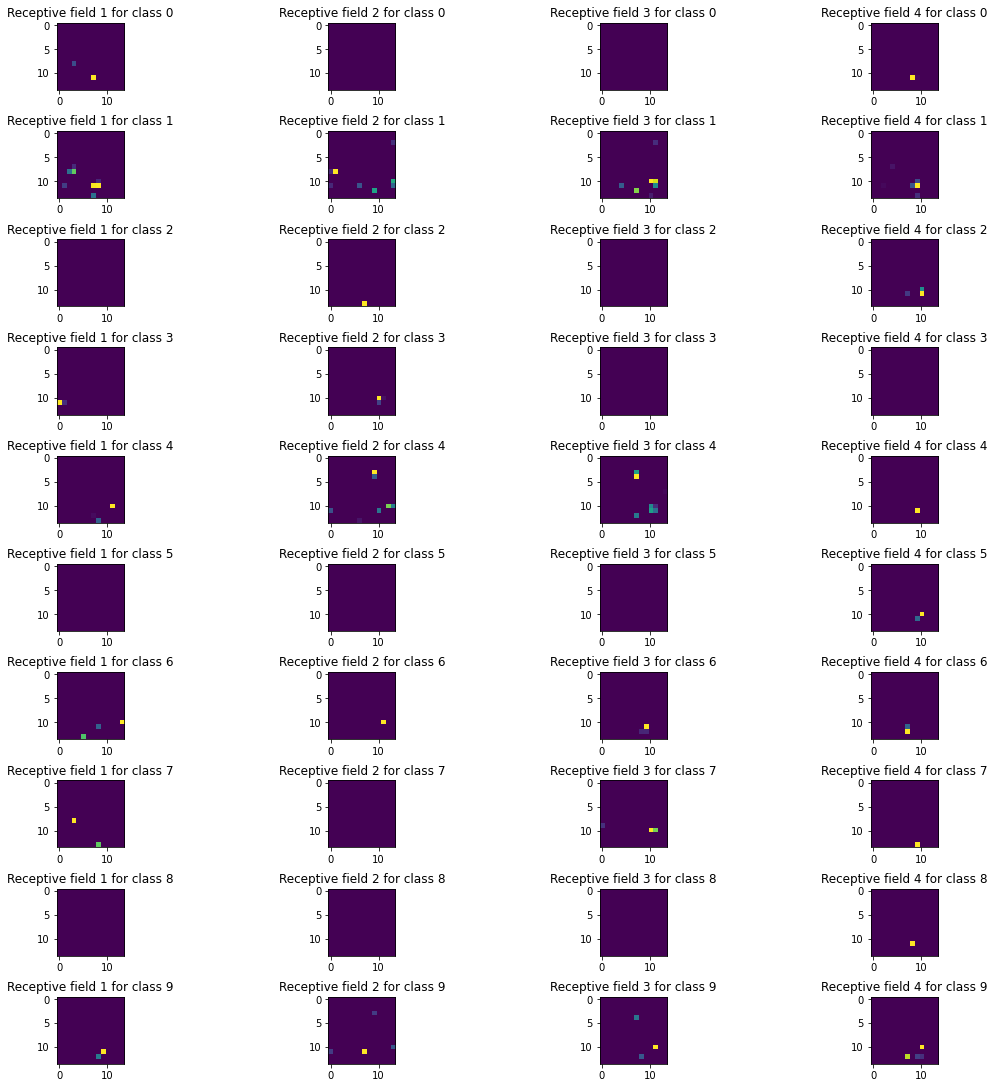

In [29]:
cnn_output_layer1 = []
#taking one image form each class
for idx in range(1,100,10):
    im = data_loader.dataset.data[test_set_idx[idx]].numpy()
    im = im.astype('float32')
    im = im/255
    y = cnn_model.model[0].apply(im, False)
    y = cnn_model.model[1].apply(y, False)
    y = cnn_model.model[2].apply(y, False)
    y = cnn_model.model[3].apply(y, False)
    y = cnn_model.model[4].apply(y, False)
    cnn_output_layer1.append(y)
    
fig, ax = plt.subplots(10,4, figsize = (15,15), constrained_layout = True)
#plt.title("CNN LAYER-1 Receptive Field for different classes")
for i in np.arange(10):
    for j in np.arange(4):
        ax[i,j].imshow(cnn_output_layer1[i][:,:,j])
        ax[i,j].set_title("Receptive field "+str(j+1) +" for class "+str(i))


# <h1><font color='blue'>Using the TSNE to visualize the bottleneck layer output.</h1>

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.000s...
[t-SNE] Computed neighbors for 100 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 13.540017
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.626083
[t-SNE] KL divergence after 500 iterations: 0.650059


[Text(0.5, 1.0, 'T-SNE projections of the Bottleneck layer')]

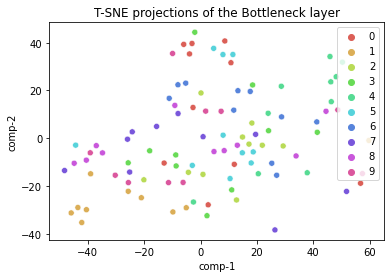

In [30]:
bottleneck_layer_output = []
#taking one image form each class
#taking one image form each class
for idx in test_set_idx:
    im = data_loader.dataset.data[idx].numpy()
    im = im.astype('float32')
    im = im/255
    y = cnn_model.model[0].apply(im, False)
    y = cnn_model.model[1].apply(y, False)
    y = cnn_model.model[2].apply(y, False)
    y = cnn_model.model[3].apply(y, False)
    y = cnn_model.model[4].apply(y, False)
    y = cnn_model.model[5].apply(y, False)
    y = cnn_model.model[6].apply(y, False)
    bottleneck_layer_output.append(y)

tsne = TSNE(n_components = 2, perplexity = 10, n_iter = 500, verbose = 1, random_state = 0)
tsne_model = tsne.fit_transform(np.array(bottleneck_layer_output))

test_lbls = []
count = len(test_set_idx)//10
for i in np.arange(10):
    test_lbls.append([i]*count)
    
df = pd.DataFrame()
df["y"] = np.array(test_lbls).flatten()
df["comp-1"] = tsne_model[:,0]
df["comp-2"] = tsne_model[:,1]

sns.scatterplot(x = "comp-1", y = "comp-2", hue = df.y.tolist(),
                palette = sns.color_palette("hls", 10),
                data = df).set(title = "T-SNE projections of the Bottleneck layer")

# <h1><font color='Green'>As shown, The samples from the same class looks closer to each other. This proves model is learning features which are useful to classify samples from different classes</h1>

# <h1><font color='blue'>Run the CNN model with Momentum based optimization.</h1>

In [31]:
OPTIMIZER = 'MOMENTUM'
alpha = 0.9
cnn_model = CNN_MODEL(28, 10)
cnn_model.build_model()
LEARNING_RATE = .001
cnn_model.do_train(data_loader, train_set_idx.copy(), test_set_idx.copy(), epochs = 15, batch_size = 1)

Epoch:: 0


<ipython-input-18-40ac57285bf9>:99: RuntimeWarning: divide by zero encountered in log
  cost = (np.dot(Y, np.log(Yhat).T) + np.dot((ones-Y), np.log(ones-Yhat).T))


Train-acc::63.3, Test-acc::49.0
Epoch:: 1
Train-acc::80.3, Test-acc::68.0
Epoch:: 2
Train-acc::84.1, Test-acc::67.0
Epoch:: 3
Train-acc::79.4, Test-acc::69.0
Epoch:: 4
Train-acc::77.2, Test-acc::67.0
Epoch:: 5
Train-acc::80.1, Test-acc::66.0
Epoch:: 6
Train-acc::80.1, Test-acc::64.0
Epoch:: 7
Train-acc::77.6, Test-acc::62.0
Epoch:: 8
Train-acc::63.8, Test-acc::51.0
Epoch:: 9
Train-acc::67.0, Test-acc::55.0
Epoch:: 10
Train-acc::71.0, Test-acc::59.0
Epoch:: 11
Train-acc::77.6, Test-acc::59.0
Epoch:: 12
Train-acc::74.6, Test-acc::56.0
Epoch:: 13
Train-acc::78.3, Test-acc::61.0
Epoch:: 14
Train-acc::72.7, Test-acc::57.0


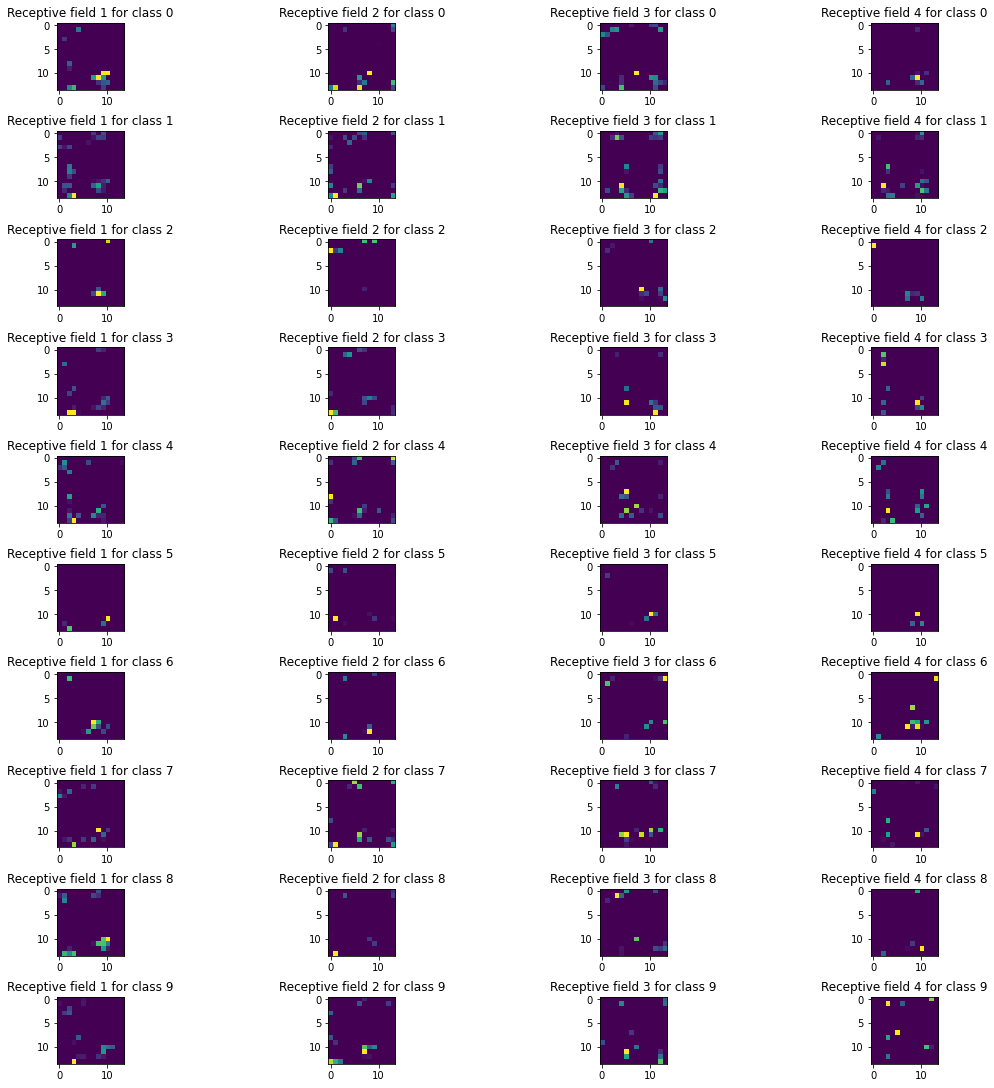

In [32]:
cnn_output_layer1 = []
#taking one image form each class
for idx in range(1,100,10):
    im = data_loader.dataset.data[test_set_idx[idx]].numpy()
    im = im.astype('float32')
    im = im/255
    y = cnn_model.model[0].apply(im, False)
    y = cnn_model.model[1].apply(y, False)
    y = cnn_model.model[2].apply(y, False)
    y = cnn_model.model[3].apply(y, False)
    y = cnn_model.model[4].apply(y, False)
    cnn_output_layer1.append(y)
    
fig, ax = plt.subplots(10,4, figsize = (15,15), constrained_layout = True)
#plt.title("CNN LAYER-1 Receptive Field for different classes")
for i in np.arange(10):
    for j in np.arange(4):
        ax[i,j].imshow(cnn_output_layer1[i][:,:,j])
        ax[i,j].set_title("Receptive field "+str(j+1) +" for class "+str(i))

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.001s...
[t-SNE] Computed neighbors for 100 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 16.713754
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.403732
[t-SNE] KL divergence after 500 iterations: 1.817827


[Text(0.5, 1.0, 'T-SNE projections of the Bottleneck layer')]

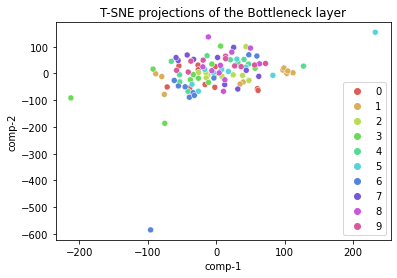

In [33]:
bottleneck_layer_output = []
#taking one image form each class
#taking one image form each class
for idx in test_set_idx:
    im = data_loader.dataset.data[idx].numpy()
    im = im.astype('float32')
    im = im/255
    y = cnn_model.model[0].apply(im, False)
    y = cnn_model.model[1].apply(y, False)
    y = cnn_model.model[2].apply(y, False)
    y = cnn_model.model[3].apply(y, False)
    y = cnn_model.model[4].apply(y, False)
    y = cnn_model.model[5].apply(y, False)
    y = cnn_model.model[6].apply(y, False)
    bottleneck_layer_output.append(y)

tsne = TSNE(n_components = 2, perplexity = 10, n_iter = 500, verbose = 1, random_state = 0)
tsne_model = tsne.fit_transform(np.array(bottleneck_layer_output))

test_lbls = []
count = len(test_set_idx)//10
for i in np.arange(10):
    test_lbls.append([i]*count)
    
df = pd.DataFrame()
df["y"] = np.array(test_lbls).flatten()
df["comp-1"] = tsne_model[:,0]
df["comp-2"] = tsne_model[:,1]

sns.scatterplot(x = "comp-1", y = "comp-2", hue = df.y.tolist(),
                palette = sns.color_palette("hls", 10),
                data = df).set(title = "T-SNE projections of the Bottleneck layer")

<h1><font color='blue'>Run the CNN model with RMSPROP optimization.</h1>

In [34]:
OPTIMIZER = 'RMSPROP'
alpha = 0.9
cnn_model = CNN_MODEL(28, 10)
cnn_model.build_model()
LEARNING_RATE = .001
cnn_model.do_train(data_loader, train_set_idx.copy(),test_set_idx.copy(), epochs = 15, batch_size = 1)

Epoch:: 0


<ipython-input-18-40ac57285bf9>:99: RuntimeWarning: divide by zero encountered in log
  cost = (np.dot(Y, np.log(Yhat).T) + np.dot((ones-Y), np.log(ones-Yhat).T))


Train-acc::49.5, Test-acc::45.0
Epoch:: 1
Train-acc::55.3, Test-acc::51.0
Epoch:: 2
Train-acc::68.8, Test-acc::65.0
Epoch:: 3
Train-acc::58.2, Test-acc::56.0
Epoch:: 4
Train-acc::67.7, Test-acc::64.0
Epoch:: 5
Train-acc::75.3, Test-acc::73.0
Epoch:: 6
Train-acc::73.0, Test-acc::64.0
Epoch:: 7
Train-acc::74.6, Test-acc::74.0
Epoch:: 8
Train-acc::75.7, Test-acc::67.0
Epoch:: 9
Train-acc::75.0, Test-acc::69.0
Epoch:: 10
Train-acc::78.6, Test-acc::71.0
Epoch:: 11
Train-acc::76.9, Test-acc::66.0
Epoch:: 12
Train-acc::76.6, Test-acc::70.0
Epoch:: 13
Train-acc::80.1, Test-acc::77.0
Epoch:: 14
Train-acc::75.4, Test-acc::68.0


# <h1><font color='blue'>Run the CNN model with GD based optimization and batch size 10.</h1>

In [35]:
OPTIMIZER = 'GD'
alpha = 0.9
cnn_model = CNN_MODEL(28, 10)
cnn_model.build_model()
LEARNING_RATE = .001
cnn_model.do_train(data_loader, train_set_idx.copy(), test_set_idx.copy(), epochs = 15, batch_size = 10)

Epoch:: 0


<ipython-input-18-40ac57285bf9>:99: RuntimeWarning: divide by zero encountered in log
  cost = (np.dot(Y, np.log(Yhat).T) + np.dot((ones-Y), np.log(ones-Yhat).T))


Train-acc::17.7, Test-acc::17.0
Epoch:: 1
Train-acc::15.9, Test-acc::16.0
Epoch:: 2
Train-acc::16.1, Test-acc::12.0
Epoch:: 3
Train-acc::15.9, Test-acc::20.0
Epoch:: 4
Train-acc::23.7, Test-acc::26.0
Epoch:: 5
Train-acc::26.1, Test-acc::22.0
Epoch:: 6
Train-acc::29.9, Test-acc::23.0
Epoch:: 7
Train-acc::30.9, Test-acc::30.0
Epoch:: 8
Train-acc::34.8, Test-acc::34.0
Epoch:: 9
Train-acc::36.4, Test-acc::33.0
Epoch:: 10
Train-acc::39.8, Test-acc::31.0
Epoch:: 11
Train-acc::37.6, Test-acc::36.0
Epoch:: 12
Train-acc::44.3, Test-acc::44.0
Epoch:: 13
Train-acc::42.9, Test-acc::33.0
Epoch:: 14
Train-acc::46.6, Test-acc::41.0


# <h1><font color='blue'>Run the CNN model with RMSPROP based optimization and batch size 10 also visualzing the receptive field after 1 and last iteration.</h1>

In [19]:
OPTIMIZER = 'RMSPROP'
alpha = 0.9
cnn_model = CNN_MODEL(28, 10)
cnn_model.build_model()
LEARNING_RATE = .001
cnn_model.do_train(data_loader, train_set_idx.copy(),test_set_idx.copy(), epochs = 1, batch_size = 10)

Epoch:: 0
Train-acc::11.7, Test-acc::13.0


[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.001s...
[t-SNE] Computed neighbors for 100 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 23.297036
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.014534
[t-SNE] KL divergence after 500 iterations: 1.645241


[Text(0.5, 1.0, 'T-SNE projections of the Bottleneck layer')]

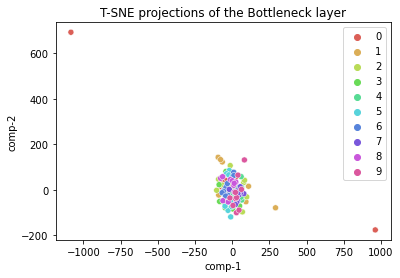

In [20]:
bottleneck_layer_output = []
#taking one image form each class
#taking one image form each class
for idx in test_set_idx:
    im = data_loader.dataset.data[idx].numpy()
    im = im.astype('float32')
    im = im/255
    y = cnn_model.model[0].apply(im, False)
    y = cnn_model.model[1].apply(y, False)
    y = cnn_model.model[2].apply(y, False)
    y = cnn_model.model[3].apply(y, False)
    y = cnn_model.model[4].apply(y, False)
    y = cnn_model.model[5].apply(y, False)
    y = cnn_model.model[6].apply(y, False)
    bottleneck_layer_output.append(y)

tsne = TSNE(n_components = 2, perplexity = 10, n_iter = 500, verbose = 1, random_state = 0)
tsne_model = tsne.fit_transform(np.array(bottleneck_layer_output))

test_lbls = []
count = len(test_set_idx)//10
for i in np.arange(10):
    test_lbls.append([i]*count)
    
df = pd.DataFrame()
df["y"] = np.array(test_lbls).flatten()
df["comp-1"] = tsne_model[:,0]
df["comp-2"] = tsne_model[:,1]

sns.scatterplot(x = "comp-1", y = "comp-2", hue = df.y.tolist(),
                palette = sns.color_palette("hls", 10),
                data = df).set(title = "T-SNE projections of the Bottleneck layer")

In [21]:
cnn_model.do_train(data_loader, train_set_idx.copy(),test_set_idx.copy(), epochs = 15, batch_size = 10)

Epoch:: 0
Train-acc::11.3, Test-acc::14.0
Epoch:: 1
Train-acc::14.4, Test-acc::17.0
Epoch:: 2
Train-acc::14.0, Test-acc::19.0
Epoch:: 3
Train-acc::16.2, Test-acc::25.0
Epoch:: 4
Train-acc::18.5, Test-acc::26.0
Epoch:: 5
Train-acc::21.3, Test-acc::25.0
Epoch:: 6
Train-acc::23.7, Test-acc::20.0
Epoch:: 7
Train-acc::26.2, Test-acc::24.0
Epoch:: 8
Train-acc::27.8, Test-acc::26.0
Epoch:: 9
Train-acc::30.1, Test-acc::30.0
Epoch:: 10
Train-acc::33.4, Test-acc::32.0
Epoch:: 11
Train-acc::36.9, Test-acc::34.0
Epoch:: 12
Train-acc::35.2, Test-acc::34.0
Epoch:: 13
Train-acc::38.1, Test-acc::32.0
Epoch:: 14
Train-acc::40.2, Test-acc::33.0


[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.000s...
[t-SNE] Computed neighbors for 100 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 20.791143
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.574394
[t-SNE] KL divergence after 500 iterations: 1.847498


[Text(0.5, 1.0, 'T-SNE projections of the Bottleneck layer')]

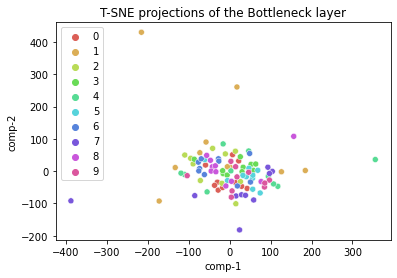

In [22]:
bottleneck_layer_output = []
#taking one image form each class
#taking one image form each class
for idx in test_set_idx:
    im = data_loader.dataset.data[idx].numpy()
    im = im.astype('float32')
    im = im/255
    y = cnn_model.model[0].apply(im, False)
    y = cnn_model.model[1].apply(y, False)
    y = cnn_model.model[2].apply(y, False)
    y = cnn_model.model[3].apply(y, False)
    y = cnn_model.model[4].apply(y, False)
    y = cnn_model.model[5].apply(y, False)
    y = cnn_model.model[6].apply(y, False)
    bottleneck_layer_output.append(y)

tsne = TSNE(n_components = 2, perplexity = 10, n_iter = 500, verbose = 1, random_state = 0)
tsne_model = tsne.fit_transform(np.array(bottleneck_layer_output))

test_lbls = []
count = len(test_set_idx)//10
for i in np.arange(10):
    test_lbls.append([i]*count)
    
df = pd.DataFrame()
df["y"] = np.array(test_lbls).flatten()
df["comp-1"] = tsne_model[:,0]
df["comp-2"] = tsne_model[:,1]

sns.scatterplot(x = "comp-1", y = "comp-2", hue = df.y.tolist(),
                palette = sns.color_palette("hls", 10),
                data = df).set(title = "T-SNE projections of the Bottleneck layer")

# <h1><font color='green'>From the above 2 TSNE plot it's clear modle is learning slowly useful features as the no. of epoch increasing, initially all the features lie in a close reason, but after 15 iterations featres from different classes are seems to be at some distance from each othere</h1>

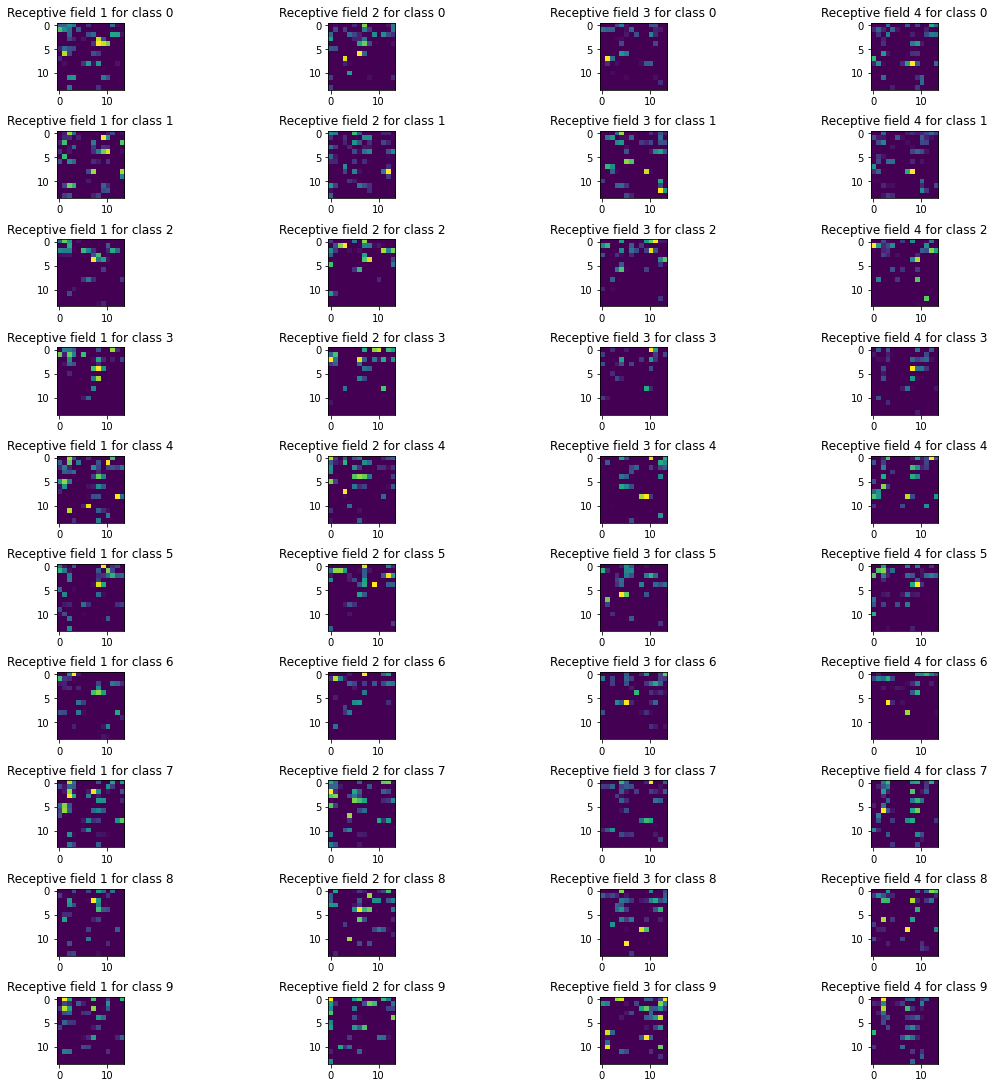

In [23]:
cnn_output_layer1 = []
#taking one image form each class
for idx in range(1,100,10):
    im = data_loader.dataset.data[test_set_idx[idx]].numpy()
    im = im.astype('float32')
    im = im/255
    y = cnn_model.model[0].apply(im, False)
    y = cnn_model.model[1].apply(y, False)
    y = cnn_model.model[2].apply(y, False)
    y = cnn_model.model[3].apply(y, False)
    y = cnn_model.model[4].apply(y, False)
    cnn_output_layer1.append(y)
    
fig, ax = plt.subplots(10,4, figsize = (15,15), constrained_layout = True)
#plt.title("CNN LAYER-1 Receptive Field for different classes")
for i in np.arange(10):
    for j in np.arange(4):
        ax[i,j].imshow(cnn_output_layer1[i][:,:,j])
        ax[i,j].set_title("Receptive field "+str(j+1) +" for class "+str(i))


In [24]:
cnn_model.do_train(data_loader, train_set_idx.copy(),test_set_idx.copy(), epochs = 50, batch_size = 10)

Epoch:: 0
Train-acc::43.0, Test-acc::34.0
Epoch:: 1
Train-acc::42.6, Test-acc::33.0
Epoch:: 2
Train-acc::45.7, Test-acc::33.0
Epoch:: 3
Train-acc::47.6, Test-acc::38.0
Epoch:: 4
Train-acc::44.9, Test-acc::34.0
Epoch:: 5
Train-acc::48.3, Test-acc::41.0
Epoch:: 6
Train-acc::47.3, Test-acc::34.0
Epoch:: 7
Train-acc::48.2, Test-acc::39.0
Epoch:: 8
Train-acc::47.6, Test-acc::40.0
Epoch:: 9
Train-acc::47.6, Test-acc::40.0
Epoch:: 10
Train-acc::50.0, Test-acc::46.0
Epoch:: 11
Train-acc::51.1, Test-acc::43.0
Epoch:: 12
Train-acc::52.2, Test-acc::40.0
Epoch:: 13
Train-acc::51.6, Test-acc::44.0
Epoch:: 14
Train-acc::52.4, Test-acc::47.0
Epoch:: 15
Train-acc::54.2, Test-acc::44.0
Epoch:: 16
Train-acc::53.6, Test-acc::44.0
Epoch:: 17
Train-acc::53.3, Test-acc::46.0
Epoch:: 18
Train-acc::54.2, Test-acc::45.0
Epoch:: 19
Train-acc::53.5, Test-acc::44.0
Epoch:: 20
Train-acc::54.7, Test-acc::43.0
Epoch:: 21
Train-acc::54.4, Test-acc::41.0
Epoch:: 22
Train-acc::56.0, Test-acc::47.0
Epoch:: 23
Train-acc:

# <h1><font color='blue'>Visualizing again after 50 iterations.</h1>

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.002s...
[t-SNE] Computed neighbors for 100 samples in 0.020s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 9.339740
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.431313
[t-SNE] KL divergence after 500 iterations: 1.403446


[Text(0.5, 1.0, 'T-SNE projections of the Bottleneck layer')]

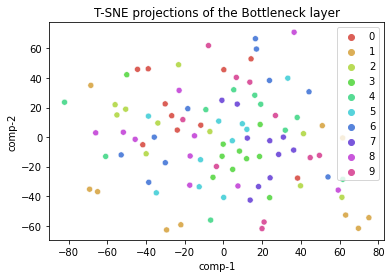

In [25]:
bottleneck_layer_output = []
#taking one image form each class
#taking one image form each class
for idx in test_set_idx:
    im = data_loader.dataset.data[idx].numpy()
    im = im.astype('float32')
    im = im/255
    y = cnn_model.model[0].apply(im, False)
    y = cnn_model.model[1].apply(y, False)
    y = cnn_model.model[2].apply(y, False)
    y = cnn_model.model[3].apply(y, False)
    y = cnn_model.model[4].apply(y, False)
    y = cnn_model.model[5].apply(y, False)
    y = cnn_model.model[6].apply(y, False)
    bottleneck_layer_output.append(y)

tsne = TSNE(n_components = 2, perplexity = 10, n_iter = 500, verbose = 1, random_state = 0)
tsne_model = tsne.fit_transform(np.array(bottleneck_layer_output))

test_lbls = []
count = len(test_set_idx)//10
for i in np.arange(10):
    test_lbls.append([i]*count)
    
df = pd.DataFrame()
df["y"] = np.array(test_lbls).flatten()
df["comp-1"] = tsne_model[:,0]
df["comp-2"] = tsne_model[:,1]

sns.scatterplot(x = "comp-1", y = "comp-2", hue = df.y.tolist(),
                palette = sns.color_palette("hls", 10),
                data = df).set(title = "T-SNE projections of the Bottleneck layer")

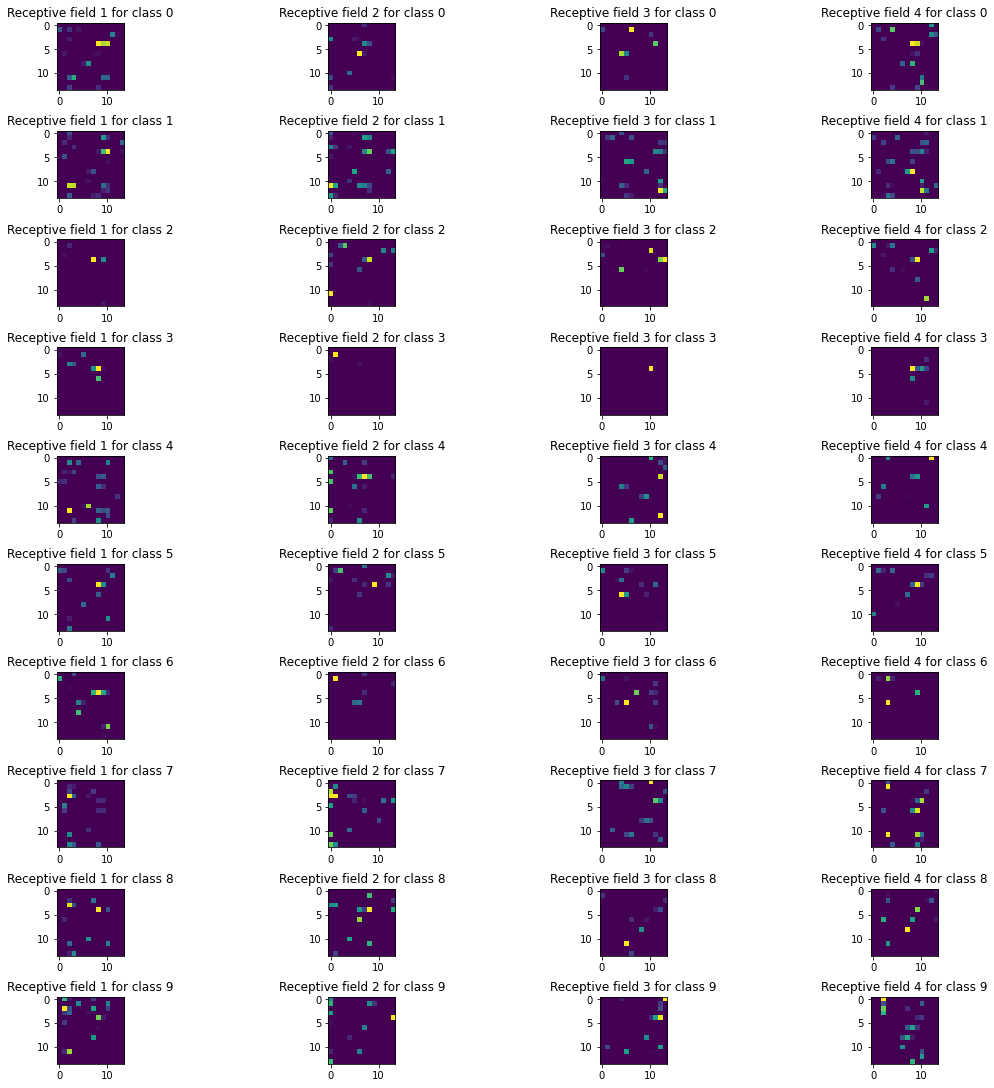

In [26]:
cnn_output_layer1 = []
#taking one image form each class
for idx in range(1,100,10):
    im = data_loader.dataset.data[test_set_idx[idx]].numpy()
    im = im.astype('float32')
    im = im/255
    y = cnn_model.model[0].apply(im, False)
    y = cnn_model.model[1].apply(y, False)
    y = cnn_model.model[2].apply(y, False)
    y = cnn_model.model[3].apply(y, False)
    y = cnn_model.model[4].apply(y, False)
    cnn_output_layer1.append(y)
    
fig, ax = plt.subplots(10,4, figsize = (15,15), constrained_layout = True)
#plt.title("CNN LAYER-1 Receptive Field for different classes")
for i in np.arange(10):
    for j in np.arange(4):
        ax[i,j].imshow(cnn_output_layer1[i][:,:,j])
        ax[i,j].set_title("Receptive field "+str(j+1) +" for class "+str(i))


# <h1><font color='blue'>Some more experimentation.</h1>

In [35]:
OPTIMIZER = 'RMSPROP'
alpha = 0.9
cnn_model = CNN_MODEL(28, 10)
cnn_model.build_model()
LEARNING_RATE = .001
cnn_model.do_train(data_loader, train_set_idx.copy(),test_set_idx.copy(), epochs = 1, batch_size = 1)

Epoch:: 0
Train-acc::51.3, Test-acc::48.0


[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.001s...
[t-SNE] Computed neighbors for 100 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 38.863047
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.778206
[t-SNE] KL divergence after 500 iterations: 1.393803


[Text(0.5, 1.0, 'T-SNE projections of the Bottleneck layer')]

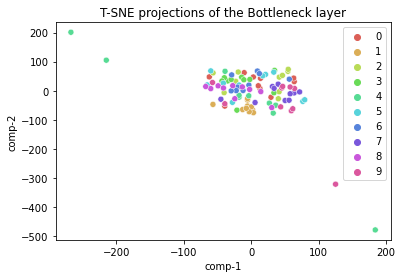

In [36]:
bottleneck_layer_output = []
#taking one image form each class
#taking one image form each class
for idx in test_set_idx:
    im = data_loader.dataset.data[idx].numpy()
    im = im.astype('float32')
    im = im/255
    y = cnn_model.model[0].apply(im, False)
    y = cnn_model.model[1].apply(y, False)
    y = cnn_model.model[2].apply(y, False)
    y = cnn_model.model[3].apply(y, False)
    y = cnn_model.model[4].apply(y, False)
    y = cnn_model.model[5].apply(y, False)
    y = cnn_model.model[6].apply(y, False)
    bottleneck_layer_output.append(y)

tsne = TSNE(n_components = 2, perplexity = 10, n_iter = 500, verbose = 1, random_state = 0)
tsne_model = tsne.fit_transform(np.array(bottleneck_layer_output))

test_lbls = []
count = len(test_set_idx)//10
for i in np.arange(10):
    test_lbls.append([i]*count)
    
df = pd.DataFrame()
df["y"] = np.array(test_lbls).flatten()
df["comp-1"] = tsne_model[:,0]
df["comp-2"] = tsne_model[:,1]

sns.scatterplot(x = "comp-1", y = "comp-2", hue = df.y.tolist(),
                palette = sns.color_palette("hls", 10),
                data = df).set(title = "T-SNE projections of the Bottleneck layer")

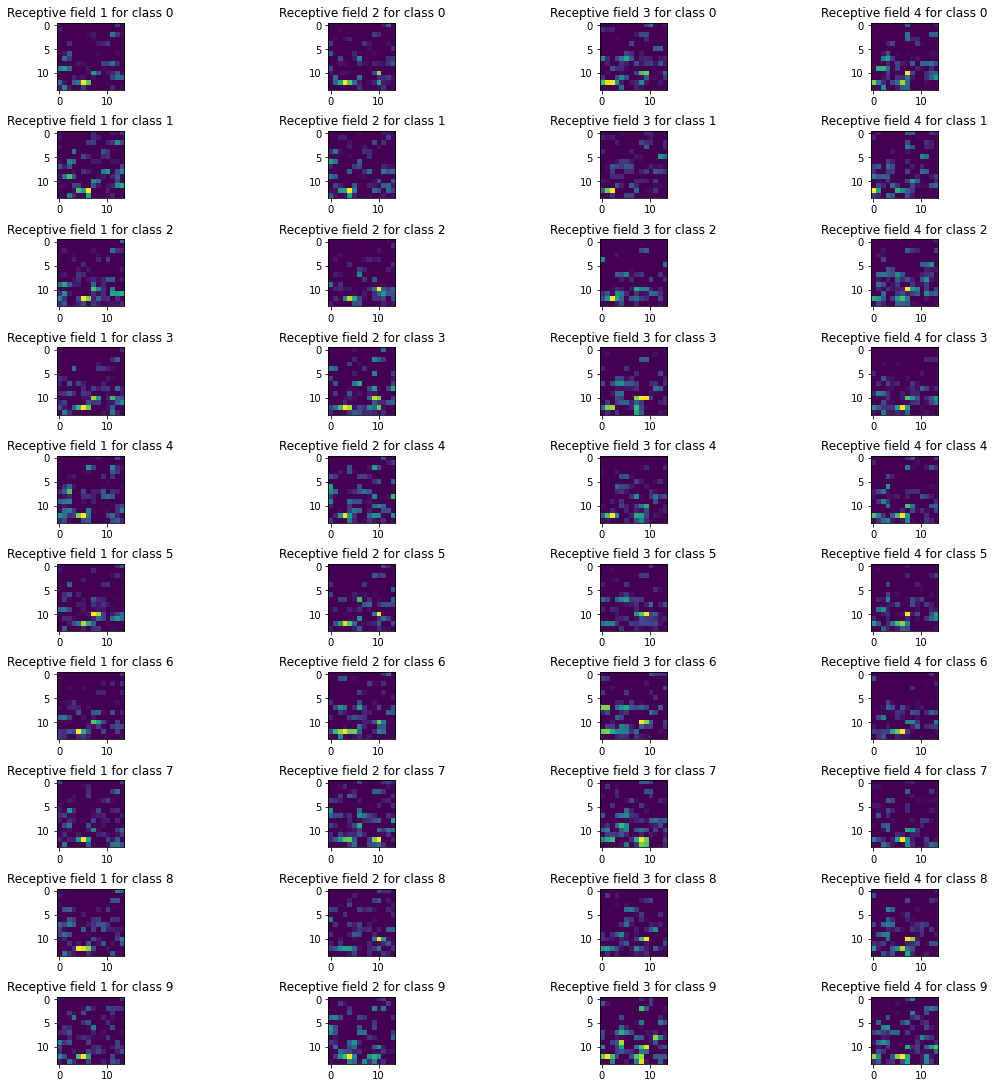

In [37]:
cnn_output_layer1 = []
#taking one image form each class
for idx in range(1,100,10):
    im = data_loader.dataset.data[test_set_idx[idx]].numpy()
    im = im.astype('float32')
    im = im/255
    y = cnn_model.model[0].apply(im, False)
    y = cnn_model.model[1].apply(y, False)
    y = cnn_model.model[2].apply(y, False)
    y = cnn_model.model[3].apply(y, False)
    y = cnn_model.model[4].apply(y, False)
    cnn_output_layer1.append(y)
    
fig, ax = plt.subplots(10,4, figsize = (15,15), constrained_layout = True)
#plt.title("CNN LAYER-1 Receptive Field for different classes")
for i in np.arange(10):
    for j in np.arange(4):
        ax[i,j].imshow(cnn_output_layer1[i][:,:,j])
        ax[i,j].set_title("Receptive field "+str(j+1) +" for class "+str(i))


In [38]:
cnn_model.do_train(data_loader, train_set_idx.copy(),test_set_idx.copy(), epochs = 14, batch_size = 1)

Epoch:: 0
Train-acc::62.6, Test-acc::56.0
Epoch:: 1


<ipython-input-18-40ac57285bf9>:99: RuntimeWarning: divide by zero encountered in log
  cost = (np.dot(Y, np.log(Yhat).T) + np.dot((ones-Y), np.log(ones-Yhat).T))


Train-acc::61.0, Test-acc::52.0
Epoch:: 2
Train-acc::78.6, Test-acc::67.0
Epoch:: 3
Train-acc::77.1, Test-acc::69.0
Epoch:: 4
Train-acc::76.0, Test-acc::64.0
Epoch:: 5
Train-acc::71.8, Test-acc::62.0
Epoch:: 6
Train-acc::80.5, Test-acc::67.0
Epoch:: 7
Train-acc::79.7, Test-acc::64.0
Epoch:: 8
Train-acc::77.6, Test-acc::65.0
Epoch:: 9
Train-acc::85.1, Test-acc::72.0
Epoch:: 10
Train-acc::87.4, Test-acc::71.0
Epoch:: 11
Train-acc::79.8, Test-acc::65.0
Epoch:: 12
Train-acc::81.4, Test-acc::69.0
Epoch:: 13
Train-acc::75.9, Test-acc::65.0


[t-SNE] Computing 28 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.001s...
[t-SNE] Computed neighbors for 100 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 58.663128
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.117920
[t-SNE] KL divergence after 251 iterations: 179769313486231570814527423731704356798070567525844996598917476803157260780028538760589558632766878171540458953514382464234321326889464182768467546703537516986049910576551282076245490090389328944075868508455133942304583236903222948165808559332123348274797826204144723168738177180919299881250404026184124858368.000000


[Text(0.5, 1.0, 'T-SNE projections of the Bottleneck layer')]

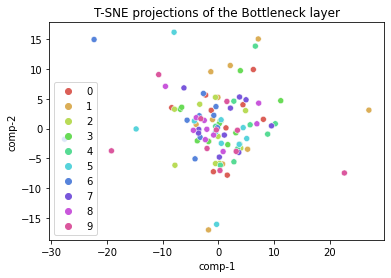

In [49]:
bottleneck_layer_output = []
#taking one image form each class
#taking one image form each class
for idx in test_set_idx:
    im = data_loader.dataset.data[idx].numpy()
    im = im.astype('float32')
    im = im/255
    y = cnn_model.model[0].apply(im, False)
    y = cnn_model.model[1].apply(y, False)
    y = cnn_model.model[2].apply(y, False)
    y = cnn_model.model[3].apply(y, False)
    y = cnn_model.model[4].apply(y, False)
    y = cnn_model.model[5].apply(y, False)
    y = cnn_model.model[6].apply(y, False)
    bottleneck_layer_output.append(y)

tsne = TSNE(n_components = 2, perplexity = 9, n_iter = 250, verbose = 1)
tsne_model = tsne.fit_transform(np.array(bottleneck_layer_output))

test_lbls = []
count = len(test_set_idx)//10
for i in np.arange(10):
    test_lbls.append([i]*count)
    
df = pd.DataFrame()
df["y"] = np.array(test_lbls).flatten()
df["comp-1"] = tsne_model[:,0]
df["comp-2"] = tsne_model[:,1]

sns.scatterplot(x = "comp-1", y = "comp-2", hue = df.y.tolist(),
                palette = sns.color_palette("hls", 10),
                data = df).set(title = "T-SNE projections of the Bottleneck layer")

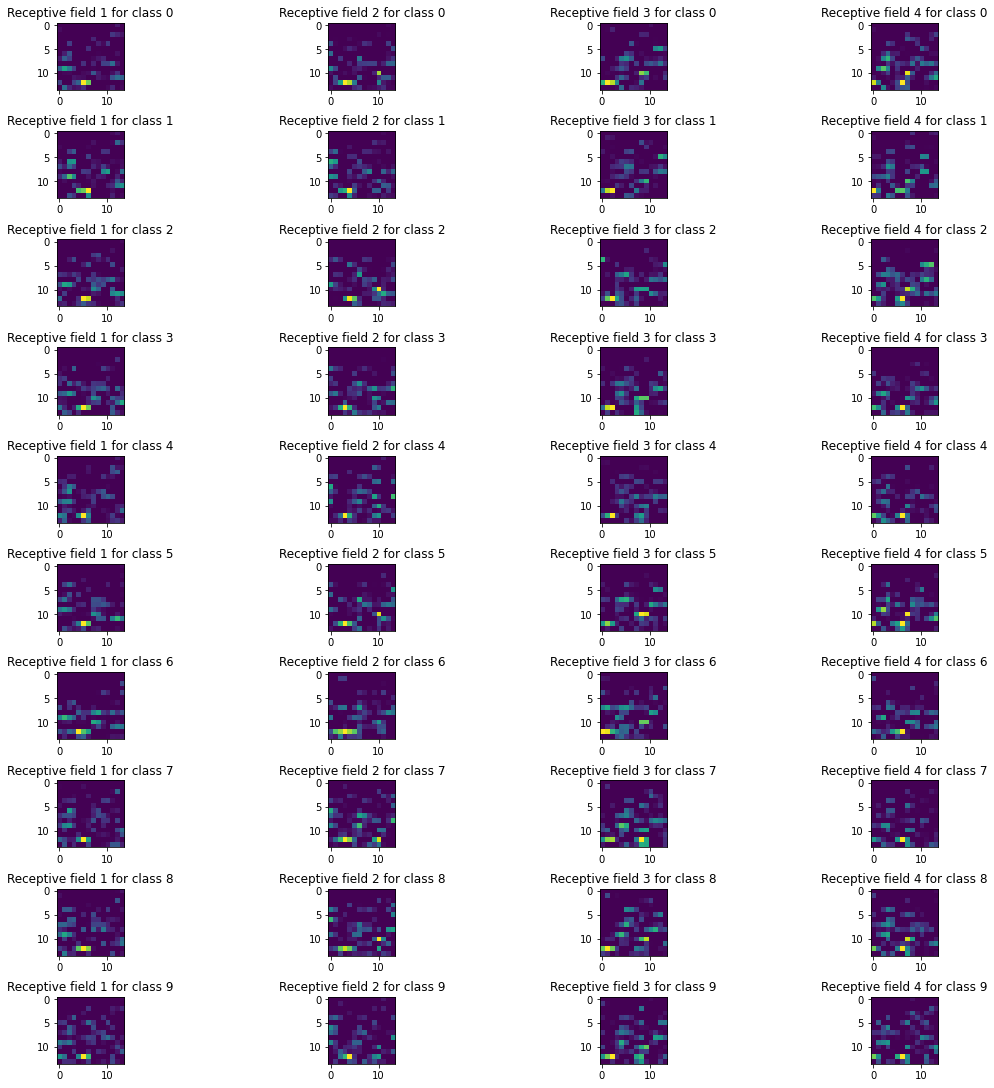

In [40]:
cnn_output_layer1 = []
#taking one image form each class
for idx in range(1,100,10):
    im = data_loader.dataset.data[test_set_idx[idx]].numpy()
    im = im.astype('float32')
    im = im/255
    y = cnn_model.model[0].apply(im, False)
    y = cnn_model.model[1].apply(y, False)
    y = cnn_model.model[2].apply(y, False)
    y = cnn_model.model[3].apply(y, False)
    y = cnn_model.model[4].apply(y, False)
    cnn_output_layer1.append(y)
    
fig, ax = plt.subplots(10,4, figsize = (15,15), constrained_layout = True)
#plt.title("CNN LAYER-1 Receptive Field for different classes")
for i in np.arange(10):
    for j in np.arange(4):
        ax[i,j].imshow(cnn_output_layer1[i][:,:,j])
        ax[i,j].set_title("Receptive field "+str(j+1) +" for class "+str(i))
